In [1]:
from pathlib import Path

from forecasting_models.univariate_models.arima.model import ARIMAForecastModel

arima_model = ARIMAForecastModel(Path("__file__").parent / Path("examples/configs/arima/arima_config_example.yaml"))

In [2]:
from data_utils.csv_utils import read_timeseries_csv

train_df = read_timeseries_csv(arima_model.config.data_path)

(22595, 1)

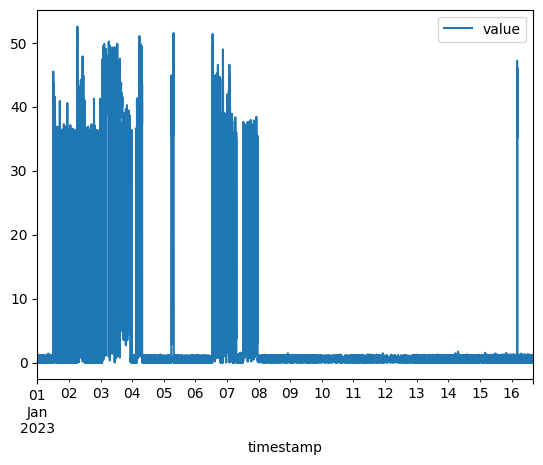

In [3]:
train_df.plot()
train_df.shape

<Axes: xlabel='timestamp'>

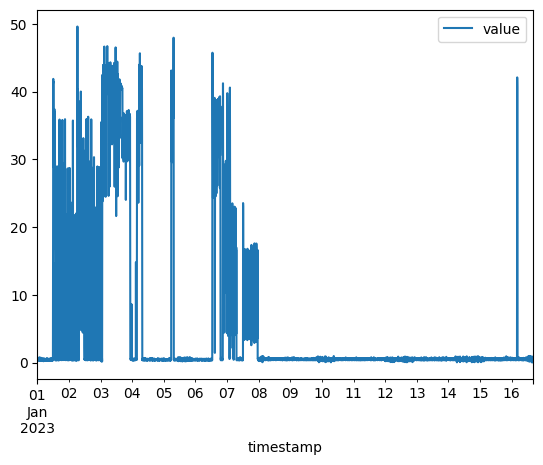

In [4]:
from data_utils.preprocessing import init_preprocess, resample_timeseries_dataframe

# preprocess training dataset to showcase the configured internal pre-processing outcome
preproc_train_df = init_preprocess(
    train_df,
    base_step=arima_model.config.preprocessing_parameters.initial_timedelta,
)
preproc_train_df = resample_timeseries_dataframe(
    preproc_train_df,
    step=arima_model.config.preprocessing_parameters.target_timedelta,
)

preproc_train_df.plot()

In [5]:
arima_model.train()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4519
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -13243.879
Date:                Thu, 11 Apr 2024   AIC                          26519.757
Time:                        10:06:36   BIC                          26622.411
Sample:                    01-01-2023   HQIC                         26555.921
                         - 01-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.797e-05      0.086      0.001      0.999      -0.168       0.168
ar.L1         -0.3871      0.094     -4.111      0.000      -0.572      -0.203
ar.L2         -0.2439      0.024    -10.128      0.000      -0.291      -0.197
ar.L3         -0.2989      0.036     -8.196      0.000      -0.370      -0.227
ar.L4         -0.2426      0.029     -8.387      0.000      -0.299      -0.186
ar.L5         -0.8355      0.022    -37.897      0.000      -0.879      -0.792
ar.L6         -0.2257      0.081     -2.782      0.005      -0.385      -0.067
ar.L7          0.1774      0.016     11.015      0.000       0.146       0.209
ma.L1         -0.0755      0.095     -0.798      0.425      -0.261       0.110
ma.L2         -0.0355      0.039     -0.909      0.363      -0.112       0.041
ma.L3          0.0530      0.025      2.078      0.038       0.003       0.103
ma.L4          0.0304      0.018      1.670      0.095      -0.005       0.066
ma.L5          0.6770      0.018     37.881      0.000       0.642       0.712
ma.L6         -0.2379      0.071     -3.367      0.001      -0.376      -0.099
ma.L7         -0.2956      0.050     -5.965      0.000      -0.393      -0.198
sigma2        20.5914      0.143    143.754      0.000      20.311      20.872
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             76290.11
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
arima_model.order()

(7, 1, 7)

In [7]:
test_df = read_timeseries_csv("./examples/sample_data/resource_usage_example_TEST.csv")

<Axes: xlabel='timestamp'>

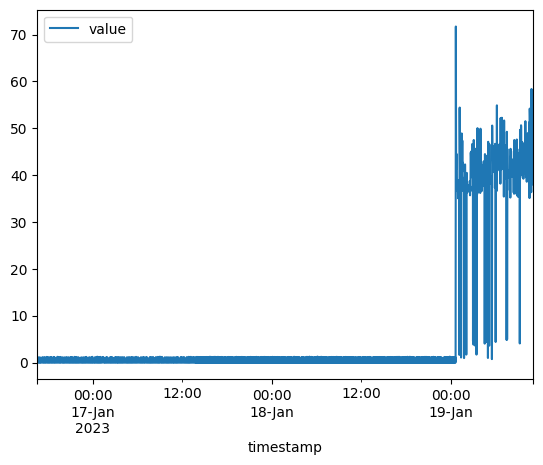

In [8]:
test_df.plot()

<Axes: xlabel='timestamp'>

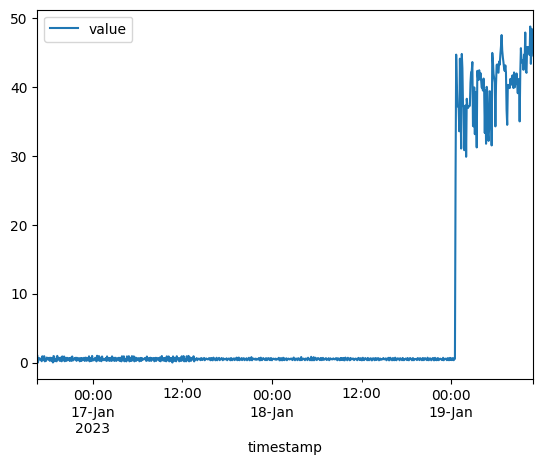

In [9]:
# preprocess training dataset to showcase the configured internal pre-processing outcome
preproc_test_df = init_preprocess(
    test_df,
    base_step=arima_model.config.preprocessing_parameters.initial_timedelta,
)
preproc_test_df = resample_timeseries_dataframe(
    preproc_test_df,
    step=arima_model.config.preprocessing_parameters.target_timedelta,
)

preproc_test_df.plot()

In [10]:
actuals, preds = arima_model.test(test_df)

In [11]:
test_eval_val, test_eval_df = arima_model.evaluate_test(
    actuals,
    preds,
    method="mse",
)

In [12]:
print(test_eval_val)

12.729555823931928


In [13]:
print(test_eval_df)

                        actual  predicted      diff
2023-01-16 16:40:00   0.955621   0.462456  0.493165
2023-01-16 16:45:00   0.007500   0.377947 -0.370447
2023-01-16 16:50:00   0.645425   0.436706  0.208719
2023-01-16 16:55:00   0.445010   0.468837 -0.023827
2023-01-16 17:00:00   0.606107   0.473689  0.132418
...                        ...        ...       ...
2023-01-19 10:45:00  43.364818  44.748319 -1.383501
2023-01-19 10:50:00  46.298526  45.102611  1.195914
2023-01-19 10:55:00  48.388678  45.065526  3.323152
2023-01-19 11:00:00  47.379692  44.520617  2.859075
2023-01-19 11:05:00  44.573609  45.156283 -0.582674

[798 rows x 3 columns]


In [14]:
anomaly_df = arima_model.flag_anomalies(actuals, preds, threshold_margin_size=20)

In [15]:
anomaly_count = len(anomaly_df[anomaly_df["is_anomaly"] == 1])
print(f"Anomaly count: {anomaly_count}")

anomaly_df.head()

Anomaly count: 6


,actual,predicted,diff,is_anomaly
2023-01-16 16:40:00,0.955621,0.462456,0.493165,0
2023-01-16 16:45:00,0.007500,0.377947,-0.370447,0
2023-01-16 16:50:00,0.645425,0.436706,0.208719,0
2023-01-16 16:55:00,0.445010,0.468837,-0.023827,0
2023-01-16 17:00:00,0.606107,0.473689,0.132418,0


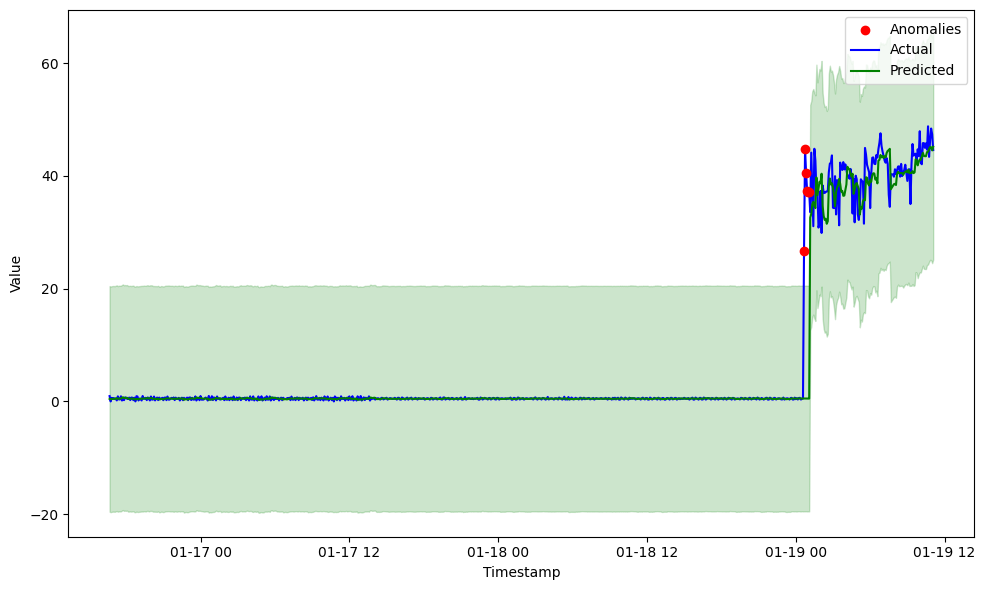

In [16]:
arima_model.plotter.plot_anomalies(anomaly_df, 20)

<Axes: xlabel='timestamp'>

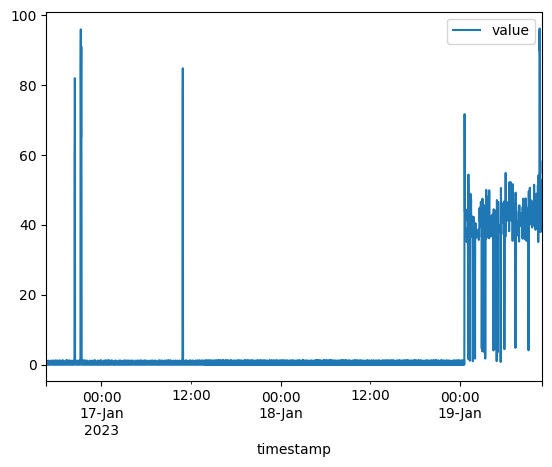

In [17]:
from pathlib import Path


test_df_w_anomalies = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_ANOMALY_TEST.csv"))

test_df_w_anomalies.plot()

In [18]:
anomaly_actuals, anomaly_preds = arima_model.test(test_df_w_anomalies)

In [19]:
anomaly_df_test = arima_model.flag_anomalies(anomaly_actuals, anomaly_preds, threshold_margin_size=20)

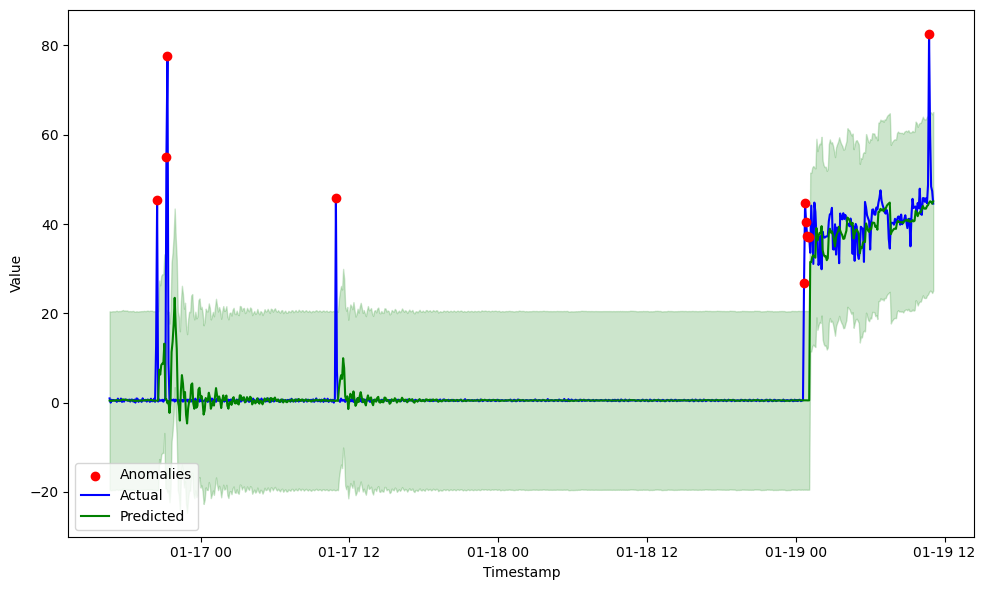

In [20]:
arima_model.plotter.plot_anomalies(anomaly_df_test, threshold_margin_size=20)

In [21]:
import pandas as pd

single_shot_preds = arima_model.predict(pd.Timestamp(preproc_test_df["value"].index[0]) - pd.Timedelta(arima_model.config.preprocessing_parameters.target_timedelta))
print(single_shot_preds)

2023-01-16 16:35:00    0.462456
2023-01-16 16:40:00    0.377947
2023-01-16 16:45:00    0.436706
2023-01-16 16:50:00    0.468837
2023-01-16 16:55:00    0.473689
2023-01-16 17:00:00    0.436465
Freq: 5min, dtype: float64


In [22]:
single_shot_eval_val, single_shot_eval_df = arima_model.evaluate_prediction(
    preproc_test_df[:arima_model.config.forecasting_parameters.forecast_horizon_size]["value"],
    method="mse",
)

In [23]:
print(single_shot_eval_val)

0.07432842183076835


In [24]:
print(single_shot_eval_df)

                       actual  predicted      diff
2023-01-16 16:35:00  0.955621   0.462456  0.493165
2023-01-16 16:40:00  0.007500   0.377947 -0.370447
2023-01-16 16:45:00  0.645425   0.436706  0.208719
2023-01-16 16:50:00  0.445010   0.468837 -0.023827
2023-01-16 16:55:00  0.606107   0.473689  0.132418
2023-01-16 17:00:00  0.498605   0.436465  0.062140
